In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using KernelDensity
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BAT
using DSP
using ImageFiltering
using Plots

In [2]:
images = load("../../data/experiment/dataset_2/m2/images.jld2"); # included saturated pixels
event_number = 2

kern = KernelFactors.gaussian((2, 2))

event = (
    cam_1 = imfilter(images["cam_1"][event_number,:,:], kern),
    cam_2 = imfilter(images["cam_2"][event_number,:,:], kern),
    cam_3 = imfilter(images["cam_3"][event_number,:,:], kern),
    cam_4 = imfilter(images["cam_4"][event_number,:,:], kern),
    population = images["charge"][event_number,:][1],
);


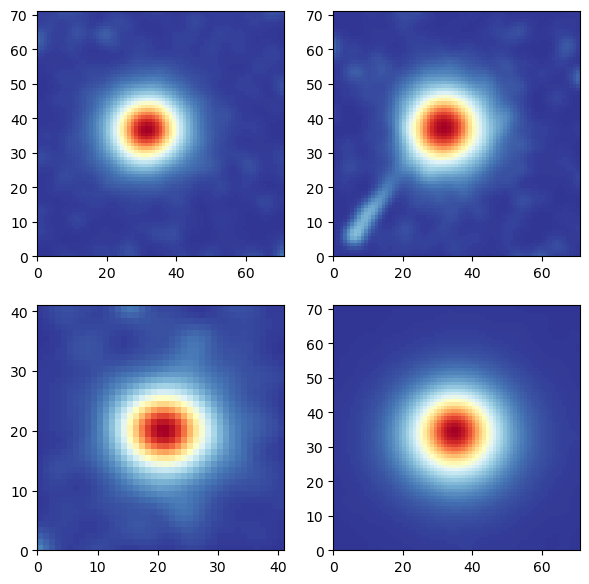

PyObject <matplotlib.collections.QuadMesh object at 0x7f12e6e8abe0>

In [3]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

In [25]:
function log_lik_diff(; e = event,)
    
    return params -> begin 
        cost = 0.0 
        for i in 1:4
            d1 = pdf.(Normal(params.mux[i], params.sigmx[i]), 1:size(e[i])[1]) # rows
            d2 = pdf.(Normal(params.muy[i], params.sigmy[i]), 1:size(e[i])[2]) # cols
            pred = params.i[i] .* (d1 * d2')
            cost -= sum((pred - e[i]).^2 / (params.fl[i]))
        end
        
        return LogDVal(cost)
    end
    
end

log_likelihood = log_lik_diff()

#11 (generic function with 1 method)

In [26]:
v = (mux = [40.28243958735675, 64.42241861048063, 20.547404771180545, 36.83604508873702], 
    muy = [20.72383690039465, 51.70843907887594, 22.58850579577588, 62.84153042615593], 
    sigmx = [8.299612986259106, 18.790565556379782, 8.275616352633026, 12.47606587162429], 
    sigmy = [7.076915297633591, 7.824038472408752, 8.663871772059448, 13.844678126565116], 
    i = [1737.1820997584541, 2367.2875362381606, 268.7516420919178, 8082.592669869264],
    fl = [0.010, 0.10, 0.10, 0.10]
)

(mux = [40.28243958735675, 64.42241861048063, 20.547404771180545, 36.83604508873702], muy = [20.72383690039465, 51.70843907887594, 22.58850579577588, 62.84153042615593], sigmx = [8.299612986259106, 18.790565556379782, 8.275616352633026, 12.47606587162429], sigmy = [7.076915297633591, 7.824038472408752, 8.663871772059448, 13.844678126565116], i = [1737.1820997584541, 2367.2875362381606, 268.7516420919178, 8082.592669869264], fl = [0.01, 0.1, 0.1, 0.1])

In [27]:
log_likelihood(v)

LogDVal{Float64}(-1.603283948870758e11)

In [32]:
prior = NamedTupleDist(
   mux = [10.. 70, 10 .. 70, 10 .. 30, 10 .. 70],
   muy = [10.. 70, 10 .. 70, 10 .. 30, 10 .. 70],
   sigmx = [3 .. 20, 3 .. 20, 3 .. 20, 3 .. 20],
   sigmy = [3 .. 20, 3 .. 20, 3 .. 20, 3 .. 20],
   i = [0 .. 10^8, 0 .. 10^8, 0 .. 10^8, 0 .. 10^8],
   fl = [0.01 .. 10^8, 0.01 .. 10^8, 0.01 .. 10^8, 0.01 .. 10^8] 
);

In [33]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
    max_nsamples_init = 500,
    max_nsteps_init = 500,
    max_time_init = Inf
)

burnin = MCMCMultiCycleBurnin(
    max_nsamples_per_cycle = 11000,
    max_nsteps_per_cycle = 11000,
    max_time_per_cycle = Inf,
    max_ncycles = 40
)

nsamples = 4*10^5
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [34]:
@time samples_tot = bat_sample(
    posterior, nchains*nsamples, algorithm,
    max_neval = nchains*nsamples,
    max_time = Inf,
);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 4 fini

102.603355 seconds (317.99 M allocations: 1.011 TiB, 25.00% gc time)


In [35]:
mode(samples_tot.result)

ShapedAsNT((mux = [37.63440378207617, 37.3404741176458, 22.736970501656046, 32.94548558407129], muy = [31.942800755744745, 32.93180672564904, 21.915569112369642, 35.82662471152524], sigmx = [5.9109876080882, 7.192812901731223, 5.212358387242753, 6.984413278448702], sigmy = [8.323483513111512, 8.766353507383565, 4.543283041605743, 7.504556799244086], i = [788951.9945151152, 1.4005162195849363e6, 320625.87415360444, 727372.3878331791], fl = [8.928137564955077e7, 8.238464742602332e7, 9.985579859587307e7, 9.130757039629073e7]))

In [ ]:
Plots.plot(samples_tot.result, vsel=[1,2,3,4,5,6,7,8])

In [ ]:
Plots.plot(samples_tot.result, vsel=[9,10,11,12,13,14,15,16])

In [ ]:
tt = rand(5,10)


In [ ]:
xxx = 1:100
yyy = 1:50

xxx_vals = pdf.(Normal(50, 5), xxx)
yyy_vals = pdf.(Normal(25, 10), yyy)
z = xxx_vals * yyy_vals'


fig, ax = plt.subplots(1,1, figsize=(7,5), )

ax.plot(xxx, xxx_vals)
ax.plot(yyy, yyy_vals)

In [ ]:
z

In [ ]:
sum(z, dims=1)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(7,5), )

ax.pcolormesh(xxx, yyy, z')